# Análise Estatística: SmartRefactor vs. Refatoração Tradicional

Este notebook reproduz, em células interativas, todo o fluxo de análise realizado no script Python:
- Carregamento e limpeza dos dados
- Estatísticas descritivas
- Testes de hipótese
- Análise de perfil dos participantes
- Geração de gráficos (boxplots)

As chamadas abaixo seguem exatamente a lógica e o código final do script fornecido.

## 1. Configuração de Ambiente e Importações

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
from scipy.stats import levene

# Caminhos para os arquivos e diretório de saída
metrics_csv = Path("./coleta.csv")
profile_csv = Path("./perfil_dos_participantes.csv")
profile = pd.read_csv(profile_csv)
metrics = pd.read_csv(metrics_csv)
out_dir = Path("./results")
out_dir.mkdir(parents=True, exist_ok=True)

## 2. Função `load_metrics`
Leitura e limpeza dos dados de métricas.

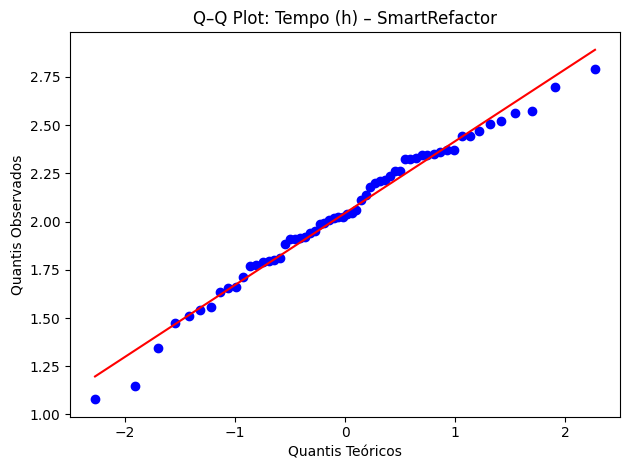

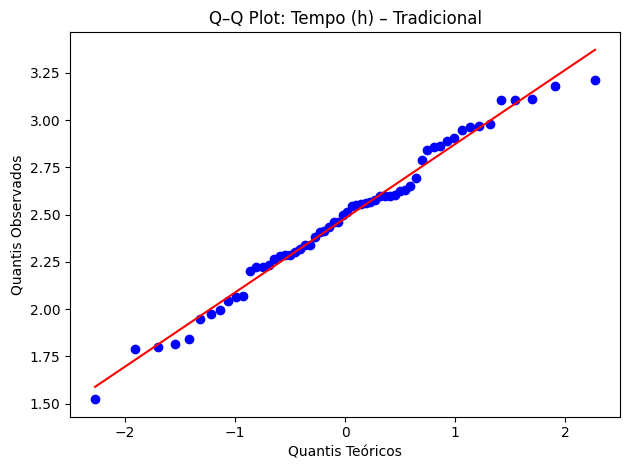

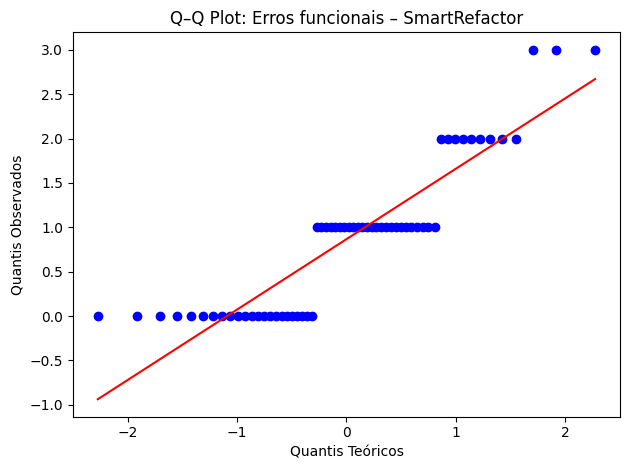

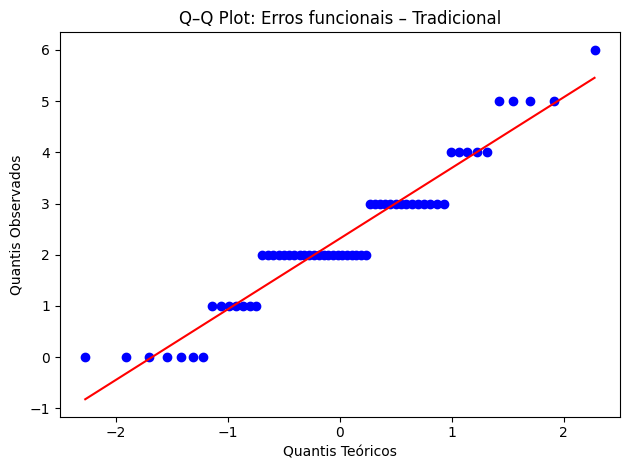

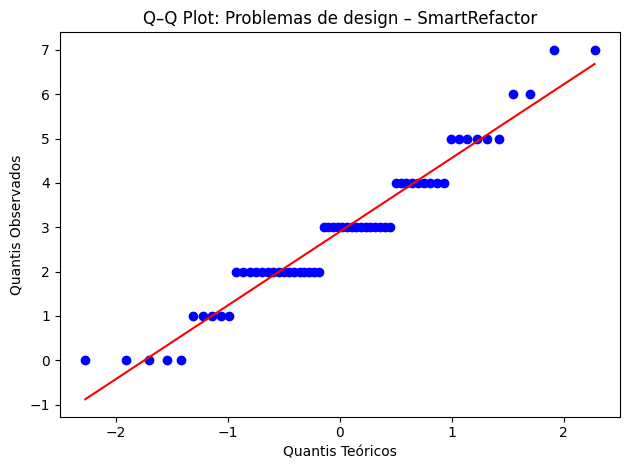

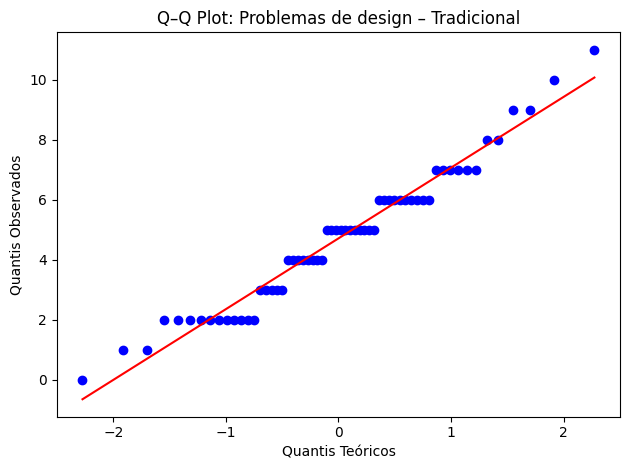

In [2]:
def load_metrics(df_raw):
    rename = {
        "Tempo (h)": "tempo_h",
        "LOC Modificadas": "loc_mod",
        "Erros Funcionais": "erros",
        "Problemas de Design": "design",
        "Ferramenta": "ferramenta",
    }
    df = df_raw.rename(columns=rename)
    for col in ["tempo_h", "loc_mod"]:
        df[col] = df[col].astype(str).str.strip()\
                                 .str.replace(",", ".", regex=False)\
                                 .astype(float)
    df["erros"] = pd.to_numeric(df["erros"], errors="coerce")
    df["design"] = pd.to_numeric(df["design"], errors="coerce")
    df = df[["ID", "tempo_h", "erros", "design", "ferramenta"]]
    return df

# Carregar e exibir as cinco primeiras linhas
df_metrics = load_metrics(metrics)
df_metrics.head()

def qq_plot(series, title):
    fig, ax = plt.subplots()
    stats.probplot(series.dropna(), dist=stats.norm, plot=ax)
    ax.get_lines()[1].set_color('red')
    ax.set_title(title)
    ax.set_xlabel("Quantis Teóricos")
    ax.set_ylabel("Quantis Observados")
    plt.tight_layout()
    plt.show()

# Primeiro, converta Tempo (h) para float:
metrics['tempo_h'] = (
    metrics['Tempo (h)']
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# 2. Converter Erros Funcionais
metrics['erros'] = (
    metrics['Erros Funcionais']
    .astype(str)                     
    .str.replace(",", ".", regex=False)
    .astype(float)                 
)

# 3. Converter Problemas de Design
metrics['design'] = (
    metrics['Problemas de Design']
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)


# Q–Q plot para tempo:
qq_plot(
    metrics.loc[metrics['Ferramenta']=="SmartRefactor", 'tempo_h'],
    title="Q–Q Plot: Tempo (h) – SmartRefactor"
)

qq_plot(
    metrics.loc[metrics['Ferramenta']=="Tradicional", 'tempo_h'],
    title="Q–Q Plot: Tempo (h) – Tradicional"
)

# Q–Q plot para Erros Funcionais:
qq_plot(
    metrics.loc[metrics['Ferramenta']=="SmartRefactor", 'erros'],
    title="Q–Q Plot: Erros funcionais – SmartRefactor"
)

qq_plot(
    metrics.loc[metrics['Ferramenta']=="Tradicional", 'erros'],
    title="Q–Q Plot: Erros funcionais – Tradicional"
)

# Q–Q plot para Problemas de Design:
qq_plot(
    metrics.loc[metrics['Ferramenta']=="SmartRefactor", 'design'],
    title="Q–Q Plot: Problemas de design – SmartRefactor"
)

qq_plot(
    metrics.loc[metrics['Ferramenta']=="Tradicional", 'design'],
    title="Q–Q Plot: Problemas de design – Tradicional"
)

## 3. Função `load_profile`
Leitura dos dados de perfil dos participantes.

In [3]:
def load_profile(df):
    rename = {
        "Formacao": "formacao",
        "Experiencia": "experiencia",
        "Conhecimento_Refatoracao": "kn_ref",
        "Conhecimento_Java": "kn_java"
    }
    return df.rename(columns=rename)

df_profile = load_profile(profile)
df_profile.head()

,ID,formacao,experiencia,kn_ref,kn_java
0,P1,Mestrado,6+ anos,Nenhum,Razoável
1,P2,Graduação,1-2 anos,Razoável,Básico
2,P3,Graduação,1-2 anos,Avançado,Razoável
3,P4,Mestrado,3-5 anos,Básico,Básico
4,P5,Mestrado,6+ anos,Nenhum,Básico


## 4. União dos DataFrames
Merge por `ID` para relacionar perfil e métricas.

In [4]:
df = pd.merge(df_metrics, df_profile, on="ID", how="left")
df.head()

,ID,tempo_h,erros,design,ferramenta,formacao,experiencia,kn_ref,kn_java
0,P1,2.600586,3,3,Tradicional,Mestrado,6+ anos,Nenhum,Razoável
1,P2,2.222081,2,5,Tradicional,Graduação,1-2 anos,Razoável,Básico
2,P3,2.855597,2,5,Tradicional,Graduação,1-2 anos,Avançado,Razoável
3,P4,2.964427,0,3,Tradicional,Mestrado,3-5 anos,Básico,Básico
4,P5,2.460526,5,6,Tradicional,Mestrado,6+ anos,Nenhum,Básico


## 5. Estatística Descritiva por Ferramenta

In [5]:
def descriptive_stats(df: pd.DataFrame):
    return (df.groupby("ferramenta")
              .agg(
                    n=("tempo_h", "count"),
                    tempo_medio=("tempo_h", "mean"),
                    tempo_dp=("tempo_h", "std"),
                    tempo_mediana=("tempo_h", "median"),
                    erros_medio=("erros", "mean"),
                    erros_dp=("erros", "std"),
                    erros_mediana=("erros", "median"),
                    design_medio=("design", "mean"),
                    design_dp=("design", "std"),
                    design_mediana=("design", "median"),
                )
                .round(3))

desc = descriptive_stats(df)
desc.to_csv(out_dir/"descriptive_stats.csv")
desc

,n,tempo_medio,tempo_dp,tempo_mediana,erros_medio,erros_dp,erros_mediana,design_medio,design_dp,design_mediana
ferramenta,,,,,,,,,,
SmartRefactor,60,2.043,0.367,2.030,0.867,0.853,1.0,2.900,1.664,3.0
Tradicional,60,2.480,0.386,2.505,2.317,1.396,2.0,4.717,2.344,5.0


## Plots

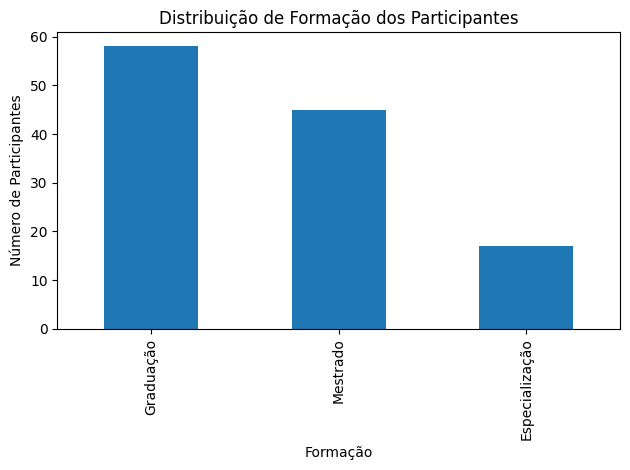

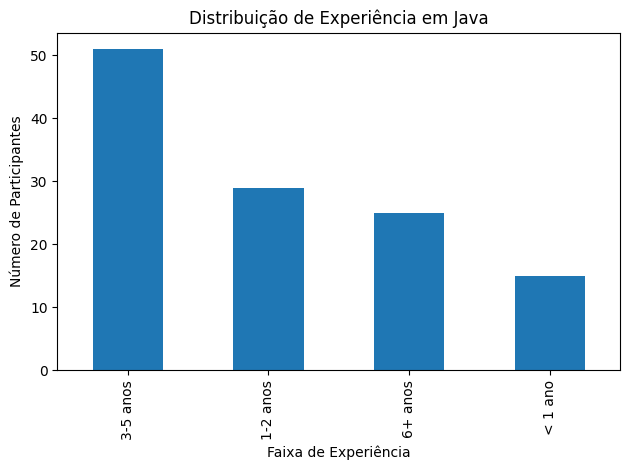

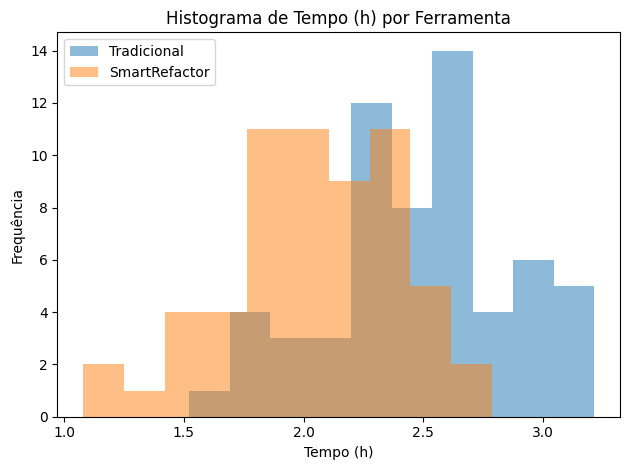

In [6]:

# Distribuição de Formação
plt.figure()
profile['Formacao'].value_counts().plot(kind='bar')
plt.title("Distribuição de Formação dos Participantes")
plt.xlabel("Formação")
plt.ylabel("Número de Participantes")
plt.tight_layout()
plt.savefig(out_dir/f"formacao.png",dpi=300)
plt.show()

# Distribuição de Experiência
plt.figure()
profile['Experiencia'].value_counts().plot(kind='bar')
plt.title("Distribuição de Experiência em Java")
plt.xlabel("Faixa de Experiência")
plt.ylabel("Número de Participantes")
plt.tight_layout()
plt.savefig(out_dir/f"exp_java.png",dpi=300)
plt.show()

# Histograma de Tempo por Ferramenta
metrics['tempo_h'] = metrics['Tempo (h)'].astype(str).str.replace(",", ".").astype(float)
plt.figure()
for tool in metrics['Ferramenta'].unique():
    subset = metrics[metrics['Ferramenta']==tool]['tempo_h']
    plt.hist(subset, bins=10, alpha=0.5, label=tool)
plt.title("Histograma de Tempo (h) por Ferramenta")
plt.xlabel("Tempo (h)")
plt.ylabel("Frequência")
plt.legend()
plt.tight_layout()
plt.savefig(out_dir/f"hist_tempo.png",dpi=300)
plt.show()



## 6. Testes de Hipótese

In [11]:
def hypothesis_tests(df: pd.DataFrame):
    results = []
    for metric, label in [
        ("tempo_h", "Tempo (h)"),
        ("erros", "Erros Funcionais"),
        ("design", "Problemas de Design"),
    ]:
        grp_smart = df[df["ferramenta"] == "SmartRefactor"][metric]
        grp_trad = df[df["ferramenta"] == "Tradicional"][metric]

        p_smart = stats.shapiro(grp_smart).pvalue
        p_trad = stats.shapiro(grp_trad).pvalue
        normal = (p_smart > 0.05) and (p_trad > 0.05)

        # Verificar homogeneidade das variâncias com o teste de Levene
        stat_lev, p_lev = levene(grp_smart, grp_trad)
        igual_var = (p_lev > 0.05)

        if normal and igual_var:
            # t de Student clássico
            stat, pval = stats.ttest_ind(grp_smart, grp_trad, equal_var=True)
            test_name = "t de Student"
            # Cohen’s d
            effect = abs(grp_smart.mean() - grp_trad.mean()) / math.sqrt(
                (grp_smart.var(ddof=1) + grp_trad.var(ddof=1)) / 2
            )
        else:
            stat, pval = stats.mannwhitneyu(grp_smart, grp_trad, alternative="two-sided")
            test_name = "Mann–Whitney"
            z = stats.norm.isf(pval/2)
            effect = abs(z) / (len(grp_smart)+len(grp_trad))**0.5

        results.append({
            "Métrica": label,
            "Teste": test_name,
            "Estatística": round(stat,3),
            "p_valor": round(pval,5),
            "Normal?": normal,
            "Efeito": round(effect,3)
        })
    return pd.DataFrame(results)

hyp = hypothesis_tests(df)
hyp.to_csv(out_dir/"hypothesis_results.csv", index=False)
hyp

,Métrica,Teste,Estatística,p_valor,Normal?,Efeito
0,Tempo (h),t de Student,-6.357,0.00000,True,1.161
1,Erros Funcionais,Mann–Whitney,697.000,0.00000,False,0.543
2,Problemas de Design,Mann–Whitney,986.000,0.00002,False,0.394


## 7. Estatísticas do Perfil dos Participantes

In [8]:
def profile_descriptive(df_profile: pd.DataFrame):
    counts = {col: df_profile[col].value_counts() for col in df_profile.columns if col!='ID'}
    return pd.DataFrame(counts)

pdesc = profile_descriptive(df_profile)
pdesc.to_csv(out_dir/"profile_stats.csv")
pdesc

,formacao,experiencia,kn_ref,kn_java
1-2 anos,NaN,29.0,NaN,NaN
3-5 anos,NaN,51.0,NaN,NaN
6+ anos,NaN,25.0,NaN,NaN
< 1 ano,NaN,15.0,NaN,NaN
Avançado,NaN,NaN,27.0,23.0
Básico,NaN,NaN,41.0,32.0
Especialização,17.0,NaN,NaN,NaN
Graduação,58.0,NaN,NaN,NaN
Mestrado,45.0,NaN,NaN,NaN
Nenhum,NaN,NaN,15.0,9.0


## 8. Influência do Perfil sobre Métricas

In [9]:
def map_ordinal(series, order):
    return series.map({cat:i for i,cat in enumerate(order)}).astype(float)

df["exp_num"] = map_ordinal(df["experiencia"],["0-1 anos","1-2 anos","3-5 anos","6+ anos"])
df["kn_ref_num"] = map_ordinal(df["kn_ref"],["Nenhum","Básico","Razoável","Avançado"])
df["kn_java_num"] = map_ordinal(df["kn_java"],["Nenhum","Básico","Razoável","Avançado"])

def profile_influence(df):
    res=[]
    for col,label in [("exp_num","Experiência"),("kn_ref_num","KN Ref"),("kn_java_num","KN Java")]:
        for metric in ["erros","design"]:
            coef,p = stats.spearmanr(df[col],df[metric],nan_policy="omit")
            res.append((label, metric, "Spearman", round(coef,3), round(p,5)))
    # Kruskal
    groups = [df[df["experiencia"]==lvl]["erros"] for lvl in ["0-1 anos","1-2 anos","3-5 anos","6+ anos"]]
    stat,p = stats.kruskal(*groups)
    res.append(("Experiência (cat)","Erros","Kruskal",round(stat,3),round(p,5)))
    return pd.DataFrame(res, columns=["Variável","Métrica","Teste","Estat","p_valor"])

pinf = profile_influence(df)
pinf.to_csv(out_dir/"profile_influence.csv", index=False)
pinf

/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_4549/2101752209.py:16: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat,p = stats.kruskal(*groups)


,Variável,Métrica,Teste,Estat,p_valor
0,Experiência,erros,Spearman,0.083,0.40001
1,Experiência,design,Spearman,-0.058,0.55912
2,KN Ref,erros,Spearman,0.141,0.12349
3,KN Ref,design,Spearman,0.027,0.77213
4,KN Java,erros,Spearman,-0.043,0.63995
5,KN Java,design,Spearman,-0.052,0.57438
6,Experiência (cat),Erros,Kruskal,NaN,NaN


## 9. Box-plots das Métricas

In [10]:
for metric,label in [("tempo_h","Tempo (h)"),("erros","Erros"),("design","Design")]:
    plt.figure()
    df.boxplot(column=metric,by="ferramenta")
    plt.title(label+" por ferramenta")
    plt.suptitle("")
    plt.savefig(out_dir/f"boxplot_{metric}.png",dpi=300)
    plt.close()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>